# Spatiotemporal Distribution of Dams

In [1]:
import os
import shutil

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pygeohydro as gh
from IPython.display import YouTubeVideo
from matplotlib.font_manager import fontManager
from tqdm.auto import tqdm

Get the data from the [National Inventory of Dams](https://damsdev.net) using [PyGeoHydro](https://github.com/cheginit/pygeohydro) package within contiguous US.

In [2]:
CRS = "esri:102008"
nid = gh.NID()
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geo = world[world.name == "United States of America"].geometry.iloc[0].geoms[0]
conus = gpd.GeoDataFrame(geometry=[conus_geo], crs=world.crs).to_crs(CRS)
conus_dams = nid.bygeom(conus_geo, "epsg:4326").to_crs(CRS)

Found 91,916 features in the requested region.


Since we're going to use dam coordinates and completion year to filter the data, let's check number of missing data to find the total available dams that include these two data.

In [3]:
missing = +conus_dams.geometry.isna().sum() + conus_dams.YEAR_COMPLETED.isna().sum()
conus_dams.shape[0] - missing

74457

Let's plot the number of missing data by state.

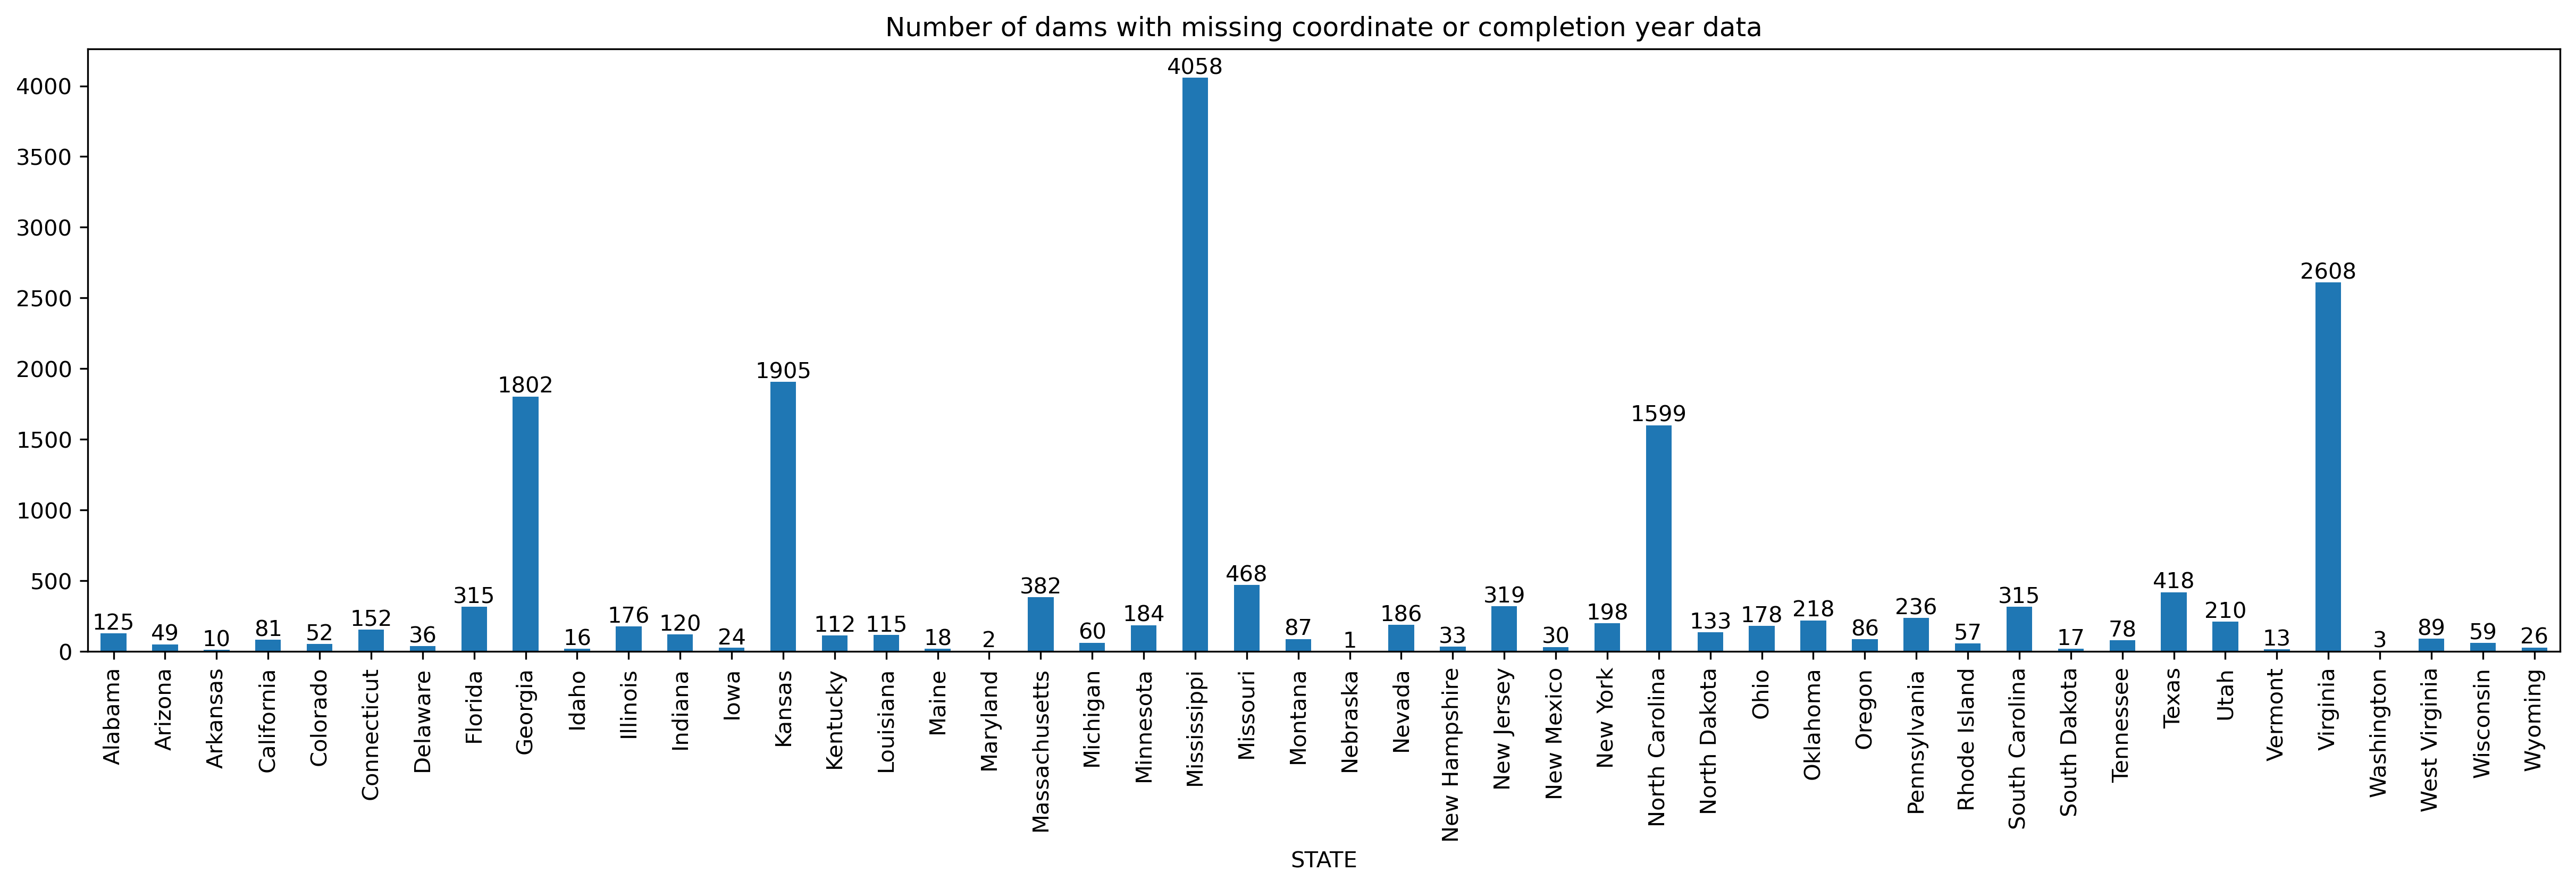

In [4]:
ax = (
    conus_dams[conus_dams.geometry.isna() | conus_dams.YEAR_COMPLETED.isna()]
    .groupby("STATE")
    .size()
    .plot.bar(figsize=(20, 5))
)
ax.set_title("Number of dams with missing coordinate or completion year data")
for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height() + 70),
        ha="center",
        va="center",
    )
ax.figure.set_dpi(300)

Plot the frames.

In [5]:
column = "DAM_HEIGHT"
cmap = "viridis"
min_q, max_q = 0.1, 0.9

label = f"{column.replace('_', ' ').title()} ({nid.attrs.loc[column].unit.lower()})"
label = "\n".join([label, f"{min_q} - {max_q} Quantile"])
norm = plt.Normalize(
    vmin=conus_dams[column].quantile(min_q), vmax=conus_dams[column].quantile(max_q)
)

dpi = 250.0
figsize = (1920.0 / dpi, 1080.0 / dpi)
font = "Lato"
indent = "\n        "
if font in {f.name for f in fontManager.ttflist}:
    matplotlib.rcParams["font.sans-serif"] = font
    matplotlib.rcParams["font.family"] = "sans-serif"
plt.ioff()

os.makedirs("tmp", exist_ok=True)


def get_ax():
    ax = conus.plot(figsize=figsize, facecolor="none", edgecolor="k")
    ax.axis(False)
    fig = ax.figure
    fig.set_dpi(dpi)
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, cax=cax, label=label)
    return ax


yr_min = conus_dams.YEAR_COMPLETED.astype("Int32").min()
yr_max = conus_dams.YEAR_COMPLETED.astype("Int32").max()
years = range(yr_min + 1, yr_max + 1)
with tqdm(total=len(years), desc="Plotting") as pbar:
    for year in years:
        pbar.set_postfix_str(f"Year: {year}")
        dams = conus_dams[conus_dams.YEAR_COMPLETED <= year]
        ax = get_ax()
        dams.plot(
            ax=ax,
            column=column,
            cmap=cmap,
            norm=norm,
            alpha=0.3,
            markersize=3,
        )
        ax.set_title(f"Dams Completed Up to {year}\nTotal = {len(dams):,}")
        h_max = dams[column].max()
        name_max = dams.iloc[dams[column].argmax()].NAME.title()
        ax.annotate(
            f"Largest Dam:{indent}Height: {h_max:.1f} ft{indent}Name: {name_max}",
            xy=(0, 0),
            xycoords=ax.transAxes,
        )
        ax.figure.savefig(f"tmp/{year}.png", bbox_inches="tight", dpi=dpi, facecolor="w")
        plt.close("all")
        pbar.update(1)

Plotting: 100%|██████████| 2021/2021 [10:51<00:00,  3.10it/s, Year: 2021]


Repeat the last frame 100 times.

In [6]:
for i in range(1, 100):
    shutil.copy(f"tmp/{years[-1]}.png", f"tmp/{years[-1] + i}.png")

Convert the frames to a video file.

In [7]:
!ffmpeg -hide_banner -loglevel panic -start_number 1641 -i tmp/%04d.png -pix_fmt yuv420p -vf scale=1920:-2 -y input_data/NID_2019.mp4

You can checkout the video here:

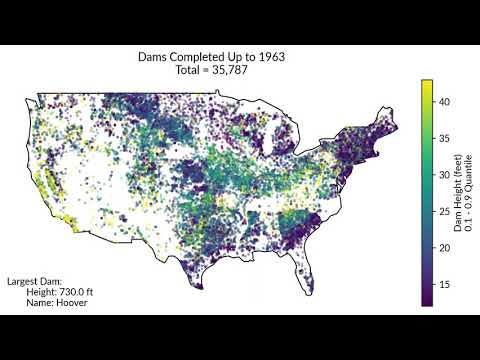

In [8]:
YouTubeVideo("AM2f9MaBjiQ")